# Import Libraries

In [1]:
import yt
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt


# Definte helper functions

In [2]:
def create_2d_plane_mask(x1, y1, x2, y2, z_range, resolution):
    """
    Create a 2D plane based on the user-defined line (x1, y1 -> x2, y2) and z-axis.
    Returns 2D arrays of X, Y, and Z coordinates.
    """
    # Generate points along the user-defined line
    
    x_vals = np.linspace(x1, x2, resolution, dtype=int)# np.abs(x2 - x1))
    y_vals = np.linspace(y1, y2, resolution, dtype=int) #np.abs(y2 - y1))

    # Create a meshgrid for Z-axis and line points
    z_vals = np.linspace(z_range[0], z_range[1], resolution, dtype=int)
    z_grid, line_grid = np.meshgrid(z_vals, np.arange(resolution), indexing='ij')
    

    # Repeat X and Y for each Z coordinate
    x_plane = np.tile(x_vals, (len(z_vals), 1))
    y_plane = np.tile(y_vals, (len(z_vals), 1))

    return x_plane, y_plane, z_grid

def get_velocity_data(obj, x_range, y_range, z_range):
    velx = obj["flash", "velx"][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('km/s').value
    vely = obj["flash", "vely"][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('km/s').value
    velz = obj["flash", "velz"][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('km/s').value
    dens = obj["flash", "dens"][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('g/cm**3').value
    temp = obj["flash", "temp"][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('K').value
    dz = obj['flash', 'dz'][x_range[0]:x_range[1], y_range[0]:y_range[1], z_range[0]:z_range[1]].to('cm').value
    mp = yt.physical_constants.mp.value  # Proton mass
    coldens = dens * dz / (1.4 * mp)
    return velx, vely, velz, coldens, temp

def read_mask_slices(mask_root, cube_shape):
    """
    Reads the mask cube from `mask_root` and saves each slice along the z-axis as an image.
    Filenames are the z-coordinates (e.g., '0.png', '1.png', ...).
    """
    mask_cube = np.zeros(cube_shape)
    
    for z in range(cube_shape[2]):
        mask_cube[z] = cv.imread(os.path.join(mask_root, f"{z}.png"), cv.IMREAD_GRAYSCALE)

    return mask_cube

# Reading HDF5 input

In [ ]:
timestamp = 420
hdf5_file = ''
ds = yt.load(hdf5_file)
center = [0, 0, 0] * yt.units.pc
arb_center = ds.arr(center, 'code_length')
left_edge = arb_center + ds.quan(-500, 'pc')
right_edge = arb_center + ds.quan(500, 'pc')
obj = ds.arbitrary_grid(left_edge, right_edge, dims=(256,) * 3)

yt : [INFO     ] 2025-01-24 23:56:38,072 Parameters: current_time              = 6721863310591746.0
yt : [INFO     ] 2025-01-24 23:56:38,072 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2025-01-24 23:56:38,073 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2025-01-24 23:56:38,074 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2025-01-24 23:56:38,074 Parameters: cosmological_simulation   = 0


# Parameter Setup

In [ ]:
lower_bound = 0
upper_bound = 256
timestamp = 420
center_z = 170

In [ ]:
velx_cube, vely_cube, velz_cube, dens_cube, temp_cube = get_velocity_data(obj, (lower_bound, upper_bound), (lower_bound, upper_bound), (lower_bound, upper_bound))

mask_img = cv.imread(os.path.join(mask_root, str(timestamp), f"{str(center_z)}.png" ), cv.IMREAD_GRAYSCALE)
mask_cube = read_mask_slices(os.path.join(mask_root, str(timestamp)), dens_cube.shape)

# Show image slices visualization

In [11]:
img = np.log10(dens_cube[:,:,170])

In [22]:
x_plane, y_plane, z_plane = create_2d_plane_mask(180,0,180,255, [0,255], 256)


In [13]:
dens_cube[x_plane,y_plane,z_plane].shape

(256, 256)

In [14]:
img2 = np.log10(dens_cube[x_plane[0][0],:,:])
img2.shape

(256, 256)

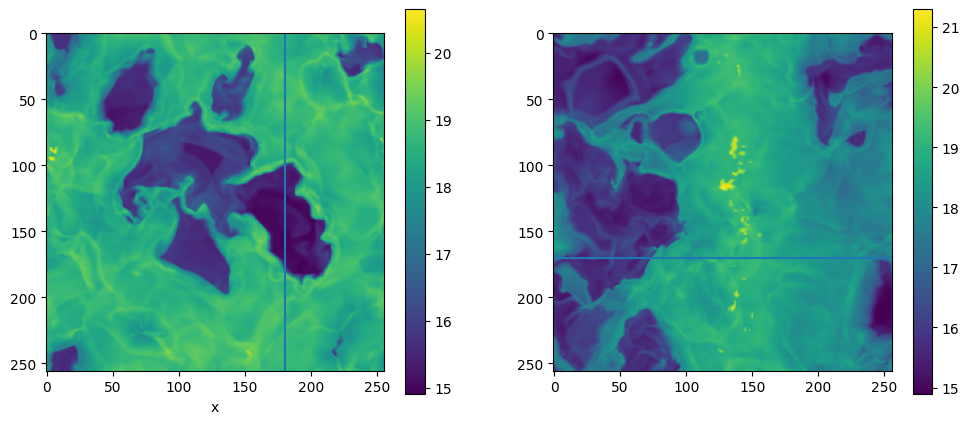

In [21]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
im = ax.imshow(img)
ax.axvline(x=180)
fig.colorbar(im)
plt.xlabel('x')

ax2 = fig.add_subplot(1,2,2)
im2=ax2.imshow(img2)
ax2.axhline(y=170)
fig.colorbar(im2)